In [15]:
library(fields)
library(ncdf4)
library(oce)

data_path = "./"

#List the name of the ncdf files in the data folder (here France interp)
lf = "ct122-35BAT-15_hr1_prof.nc"
data = read.argo(paste(data_path,lf,sep = ""), debug = getOption("oceDebug"), processingLog = "log.txt")

data

argo object, from file '/media/disk2/roquet/alice/ct122-35BAT-15_hr1_prof.nc', has data as follows.
   time [1:635]: 2016-02-16 15:50:00, 2016-02-17 05:00:00, ..., 2016-09-26 03:10:00, 2016-09-26 09:59:59
   latitude [1:635]: -49,396, -50,155, ..., -49,957, -49,641
   longitude [1:635]: 70,128, 70,304, ..., 70,233, 70,375
   pressure, a 1000x635 array with value 1 at [1,1] position
   pressureAdjusted, a 1000x635 array with value 1 at [1,1] position
   pressureAdjustedError, a 1000x635 array with value NA at [1,1] position
   temperature, a 1000x635 array with value 6,543 at [1,1] position
   temperatureAdjusted, a 1000x635 array with value 6,551576 at [1,1] position
   temperatureAdjustedError, a 1000x635 array with value 0,05 at [1,1] position
   salinity, a 1000x635 array with value 33,512 at [1,1] position
   salinityAdjusted, a 1000x635 array with value 33,50585 at [1,1] position
   salinityAdjustedError, a 1000x635 array with value 0,05 at [1,1] position

In [16]:
summary(data)

Argo Summary
------------

* Source:              "/media/disk2/roquet/alice/ct122-35BAT-15_hr1_prof.nc"
* id:                  "00057660"
* Profiles:            635 delayed; 0 adjusted; 0 realtime
* Time ranges from 2016-02-16 15:50:00 to 2016-09-26 09:59:59 with 635 samples and mean increment 8,43244 hour
* Data Overview

                                              Min.    Mean    Max.     Dim.    NAs        OriginalName
    latitude [°N]                          -57,906 -53,543 -49,396      635      0            LATITUDE
    longitude [°E]                          20,372  38,418  70,375      635      0           LONGITUDE
    pressure [dbar]                              1   500,5    1000 1000x635      0                PRES
    pressureAdjusted [dbar]                      1   500,5    1000 1000x635      0       PRES_ADJUSTED
    pressureAdjustedError [dbar]                NA      NA      NA 1000x635 635000 PRES_ADJUSTED_ERROR
    temperature [°C, ITS-90]              -0,65155  1,66

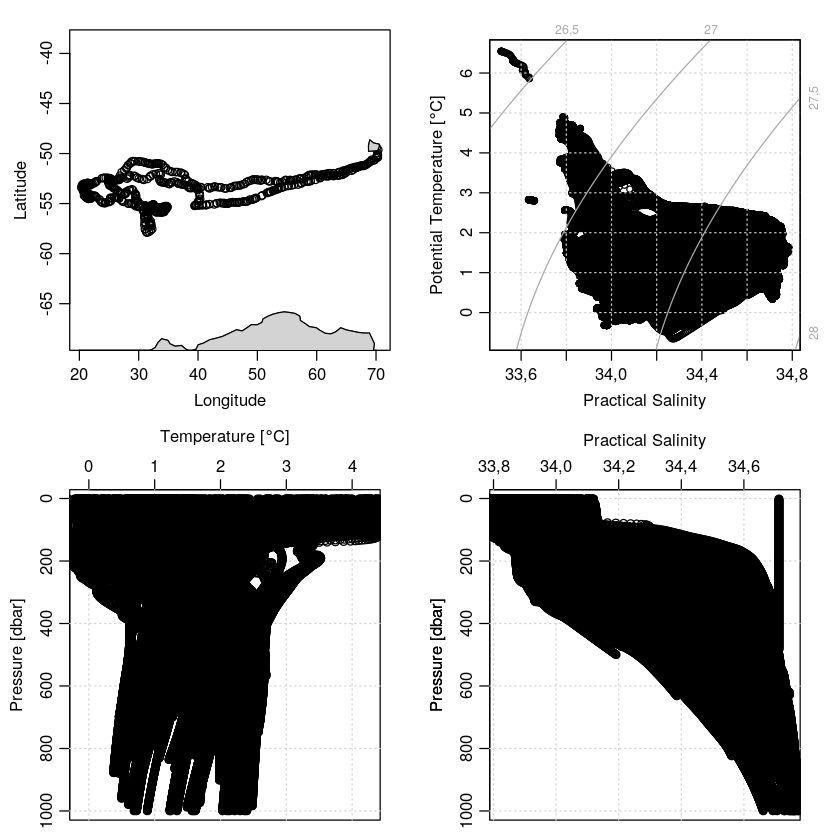

In [17]:
plot(handleFlags(data), which=c(1, 4, 6, 5))

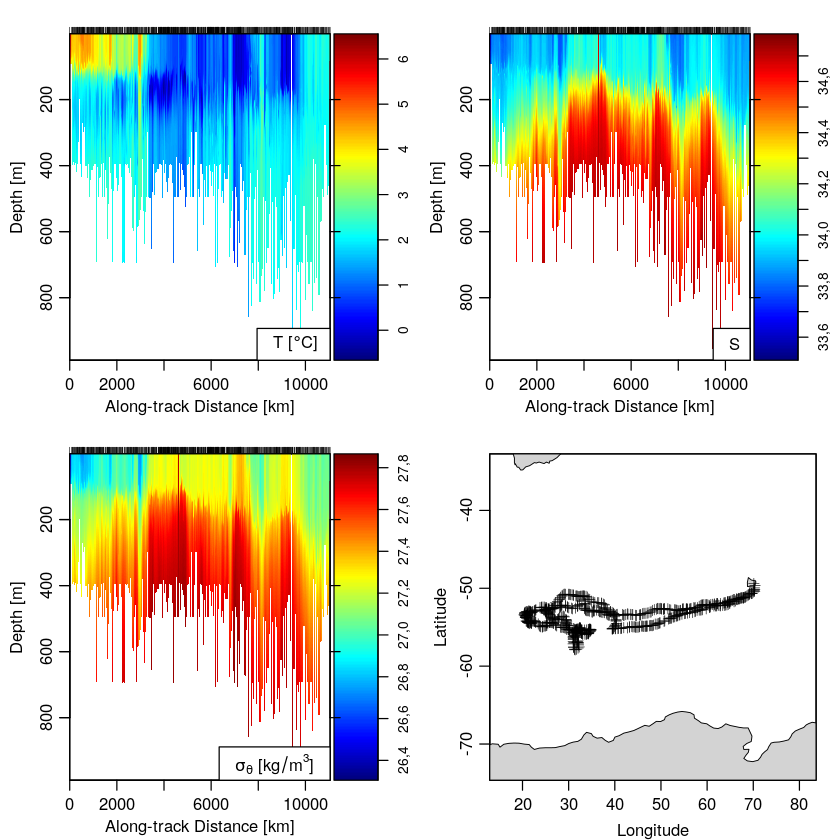

In [18]:
section = as.section(data)
plot(section, which=c(1,2,3,99), ztype='image', xtype="track")

Warning message in oce::as.ctd(data):
“using just column 1 of matrix data; use the 'profile' argument to select a specific profile or try as.section() to keep all columns”

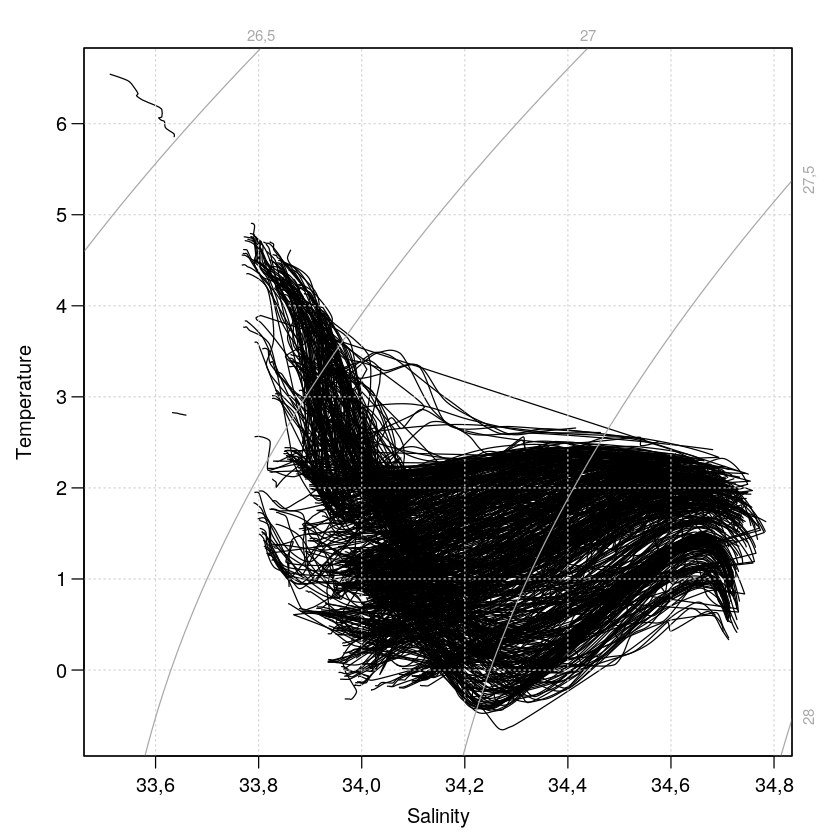

In [26]:
####################Plot the profiles in a T-S diagram (oce package)
TS.ctd = oce::as.ctd(data)   #Transform the data into a ctd object
oce::plotTS(data,las = 1,typ = 'l',xlab = "Salinity",ylab = "Temperature") #plot the TS diagram, each line is a profile


In [20]:
MLD.DK <- function(depth, # vector for depth, can be negative but results will be positive
                   variable, # temperature or density
                   threshold, # defines the threshold value that markes the end of the MLD
                   depth.max = max(abs(depth)) # maximum depth to be plotted, uses absolute value of max depth if no value is supplied
)
{
  if(all(is.na(variable))){return(NA)}
  index <- !is.na(variable)
  depth <- abs(depth) # in case depth values are negative
  depth <- depth[index]
  variable <- variable[index]
  threshold <- abs(threshold) # in case threshold is provided negative
  data <- data.frame(depth, variable) # combines depth and variable into df
  data$delta <- abs(unique(data$variable[data$depth==min(data$depth, na.rm = TRUE)]) - data$variable) # unique() in case the min(depth) occures more than once
  #if(depth.max==max(depth)) {print("no depth.max supplied, using max(depth) instead")}
  if(max(data$delta, na.rm = TRUE)<threshold) # test if the threshold is exceeded at any depth
  {
    #plot(variable, depth, ylim = c(depth.max,0), xlim = c(min(variable)-threshold*2, max(variable)+threshold*2)) # plots variable over depth
    #abline(v = c(variable[depth==min(depth)]+threshold, variable[depth==min(depth)]-threshold), col = "red") # draws vertical lines where the threshold of variable is
    #text(x = variable[depth==min(depth)], y = min(depth), "<- threshold ->", col = "red", pos = 3, offset = 0.2) 
    #print(paste("The thereshold is not exceeded. The water column is well mixed to the maximum depth of", max(depth),"[units of variable]",sep=" "))
    return(NA)
  }
  else # run if water is stratified according to threshold
  {
    MLD <- min(data$depth[data$delta>=threshold], na.rm = TRUE) # finds the lowest depth for all samples that exceed the threshold
    #plot(variable, depth, ylim = c(depth.max,0)) # plots variable over depth
    #abline(h = MLD, col = "red") # adds a horizontal line crossing y (depth) at MLD
    #text(x = mean(variable), y = MLD, paste("MLD =",MLD), col = "red", pos = 3) # adds text above (pos = 3) the line to the plot
    #print(paste("mixed layer depth is", MLD, "[units of depth]", sep = " ")) # prints the result in text form
    return(MLD) # writes the MLD into an object
  }
}



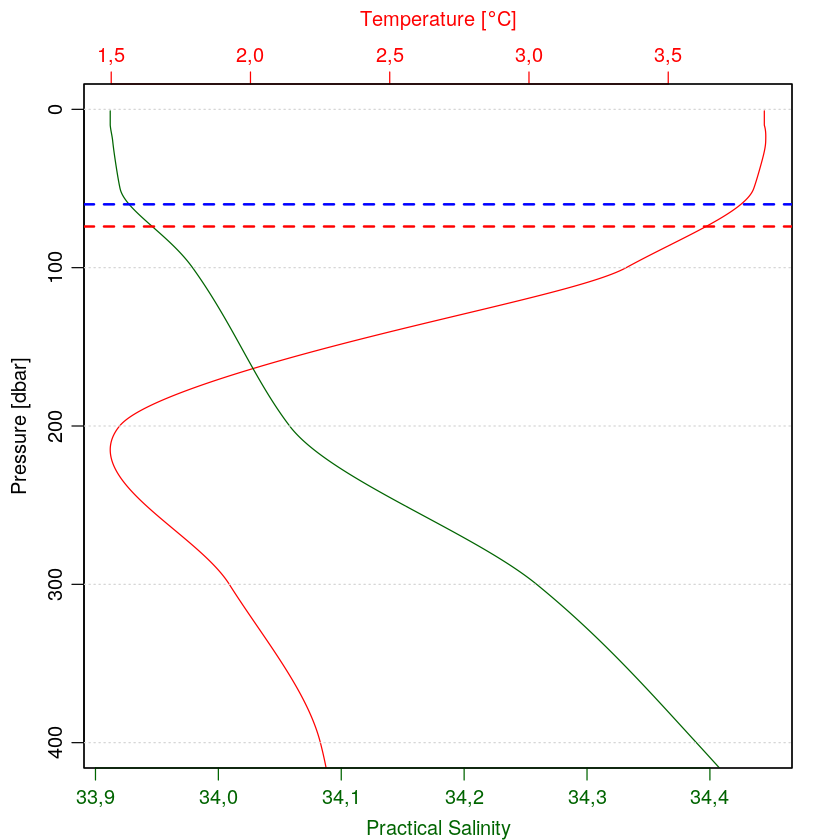

In [21]:
TS.ctd = oce::as.ctd(data,profile=61)   #Transform the data into a ctd object
mld_T = MLD.DK(depth = TS.ctd[['pressure']], variable = TS.ctd[['temperature']], threshold = 0.2)
mld_sig = MLD.DK(depth = TS.ctd[['pressure']], variable = swSigma0(TS.ctd), threshold = 0.02)   

plotProfile(TS.ctd,xtype='salinity+temperature',plim=c(400,0))
abline(h=mld_T, lwd=2, lty="dashed", col="red")
abline(h=mld_sig, lwd=2, lty="dashed", col="blue")

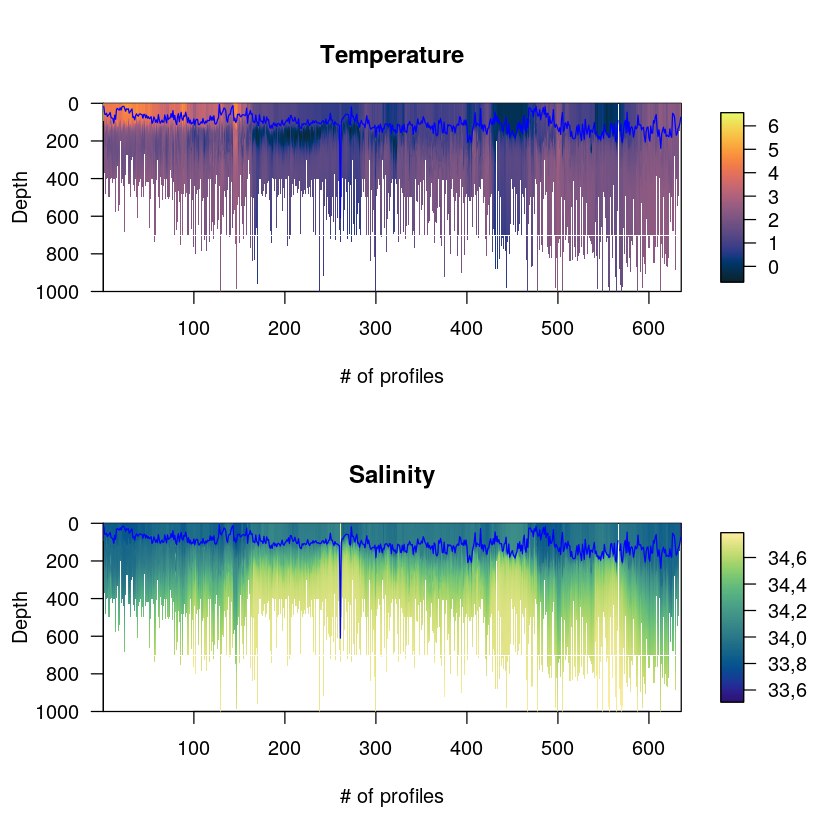

In [28]:
# plot section with contour of mixed-layer depth

# compute MLD
mld_sig <- 0*data[['latitude']]
for (ii in 1:length(data[['time']]))
    {
    TS.ctd = oce::as.ctd(data,profile=ii)
    mld_sig[ii] = MLD.DK(depth = TS.ctd[['pressure']], variable = swSigma0(TS.ctd), threshold = 0.02)    
    }

# plot section
section = as.section(data)
prof <- data[['pressure']][,1]
Temp <- data[['temperature']]
Sal  <- data[['salinity']]
####################Plot sections of T and S along number of profile
par(mfrow = c(2,1))  #create a figure panels of 2 lines and 1 columns
fields::image.plot(1:dim(Temp)[2],prof,t(Temp),las = 1,col = oce.colorsTemperature(200)
  ,ylim = c(dim(Temp)[1],0) #reverse the y axis
  ,xlab = "# of profiles",ylab = "Depth",main = "Temperature")
lines(1:dim(Temp)[2],mld_sig, pch = 1, col="blue")
fields::image.plot(1:dim(Sal)[2],prof,t(Sal),las = 1,col = oce.colorsSalinity(200)
  ,ylim = c(dim(Temp)[1],0)
  ,xlab = "# of profiles",ylab = "Depth",main = "Salinity")
lines(1:dim(Temp)[2],mld_sig, pch = 1, col="blue")
